In [1]:
from livelossplot import PlotLossesKeras
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
import shutil
import pathlib

%matplotlib inline

np.random.seed(100)

Using TensorFlow backend.


# Prepare data

Series([], dtype: float64)


There are 9850 total images.
Trainable...
There are 60 total classes.
There are 548 training images.
There are 167 validation images.
There are 214 test images.
After data filtering


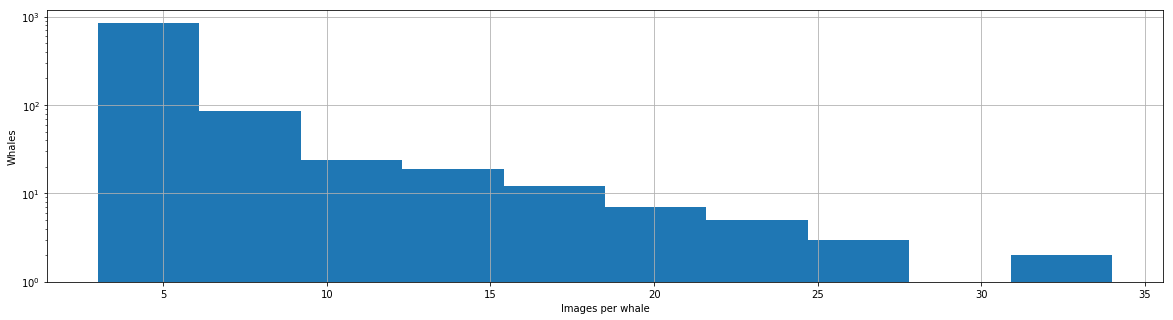

In [2]:
df = pd.read_csv("train.csv", header = 0)
display(df.std())

total_images = len(df)

# drop rows with new_whale because it is used to label various unknown flukes yet
df = df[df.Id != 'new_whale']

# use targets with 3+ samples
df = df.groupby("Id").filter(lambda x: len(x) >= 3)

# Use top N targets by image count
value_counts = df.Id.value_counts()
top_hitters = value_counts.nlargest(60).index
df = df[df['Id'].isin(top_hitters)]

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_ylabel("Whales")
ax.set_xlabel("Images per whale")
value_counts.hist(ax=ax,figsize=(20,5),bins=10, bottom=1)

classes = df.Id.unique()
num_classes = len(classes)

X_train = []; y_train = []

X_test = []; y_test = []

X_valid = []; y_valid = []

for whale_id in classes:
    df_whale = df[df.Id == whale_id]
    
    X_whale = np.array([os.path.join(os.getcwd(), 'train', s) for s in df_whale.Image])
    y_whale = np.array(df_whale.Id.values)
    
    X_train_whale, X_test_whale, y_train_whale, y_test_whale = \
        train_test_split(X_whale, y_whale, test_size=0.2, random_state=1)
    X_test.extend(X_test_whale)
    y_test.extend(y_test_whale)
    
    X_train_whale, X_valid_whale, y_train_whale, y_valid_whale = \
        train_test_split(X_train_whale, y_train_whale, test_size=0.2, random_state=1)
    X_train.extend(X_train_whale)
    y_train.extend(y_train_whale)
    X_valid.extend(X_valid_whale)
    y_valid.extend(y_valid_whale)

print('\nThere are %d total images.' % total_images)
print("Trainable...")
print('There are %d total classes.' % num_classes)

print('There are %d training images.' % len(X_train))
print('There are %d validation images.' % len(X_valid))
print('There are %d test images.' % len(X_test))

print("After data filtering")

df.describe()

workers = 8
batch_size = 32

# Visualize the First 12 Training Images

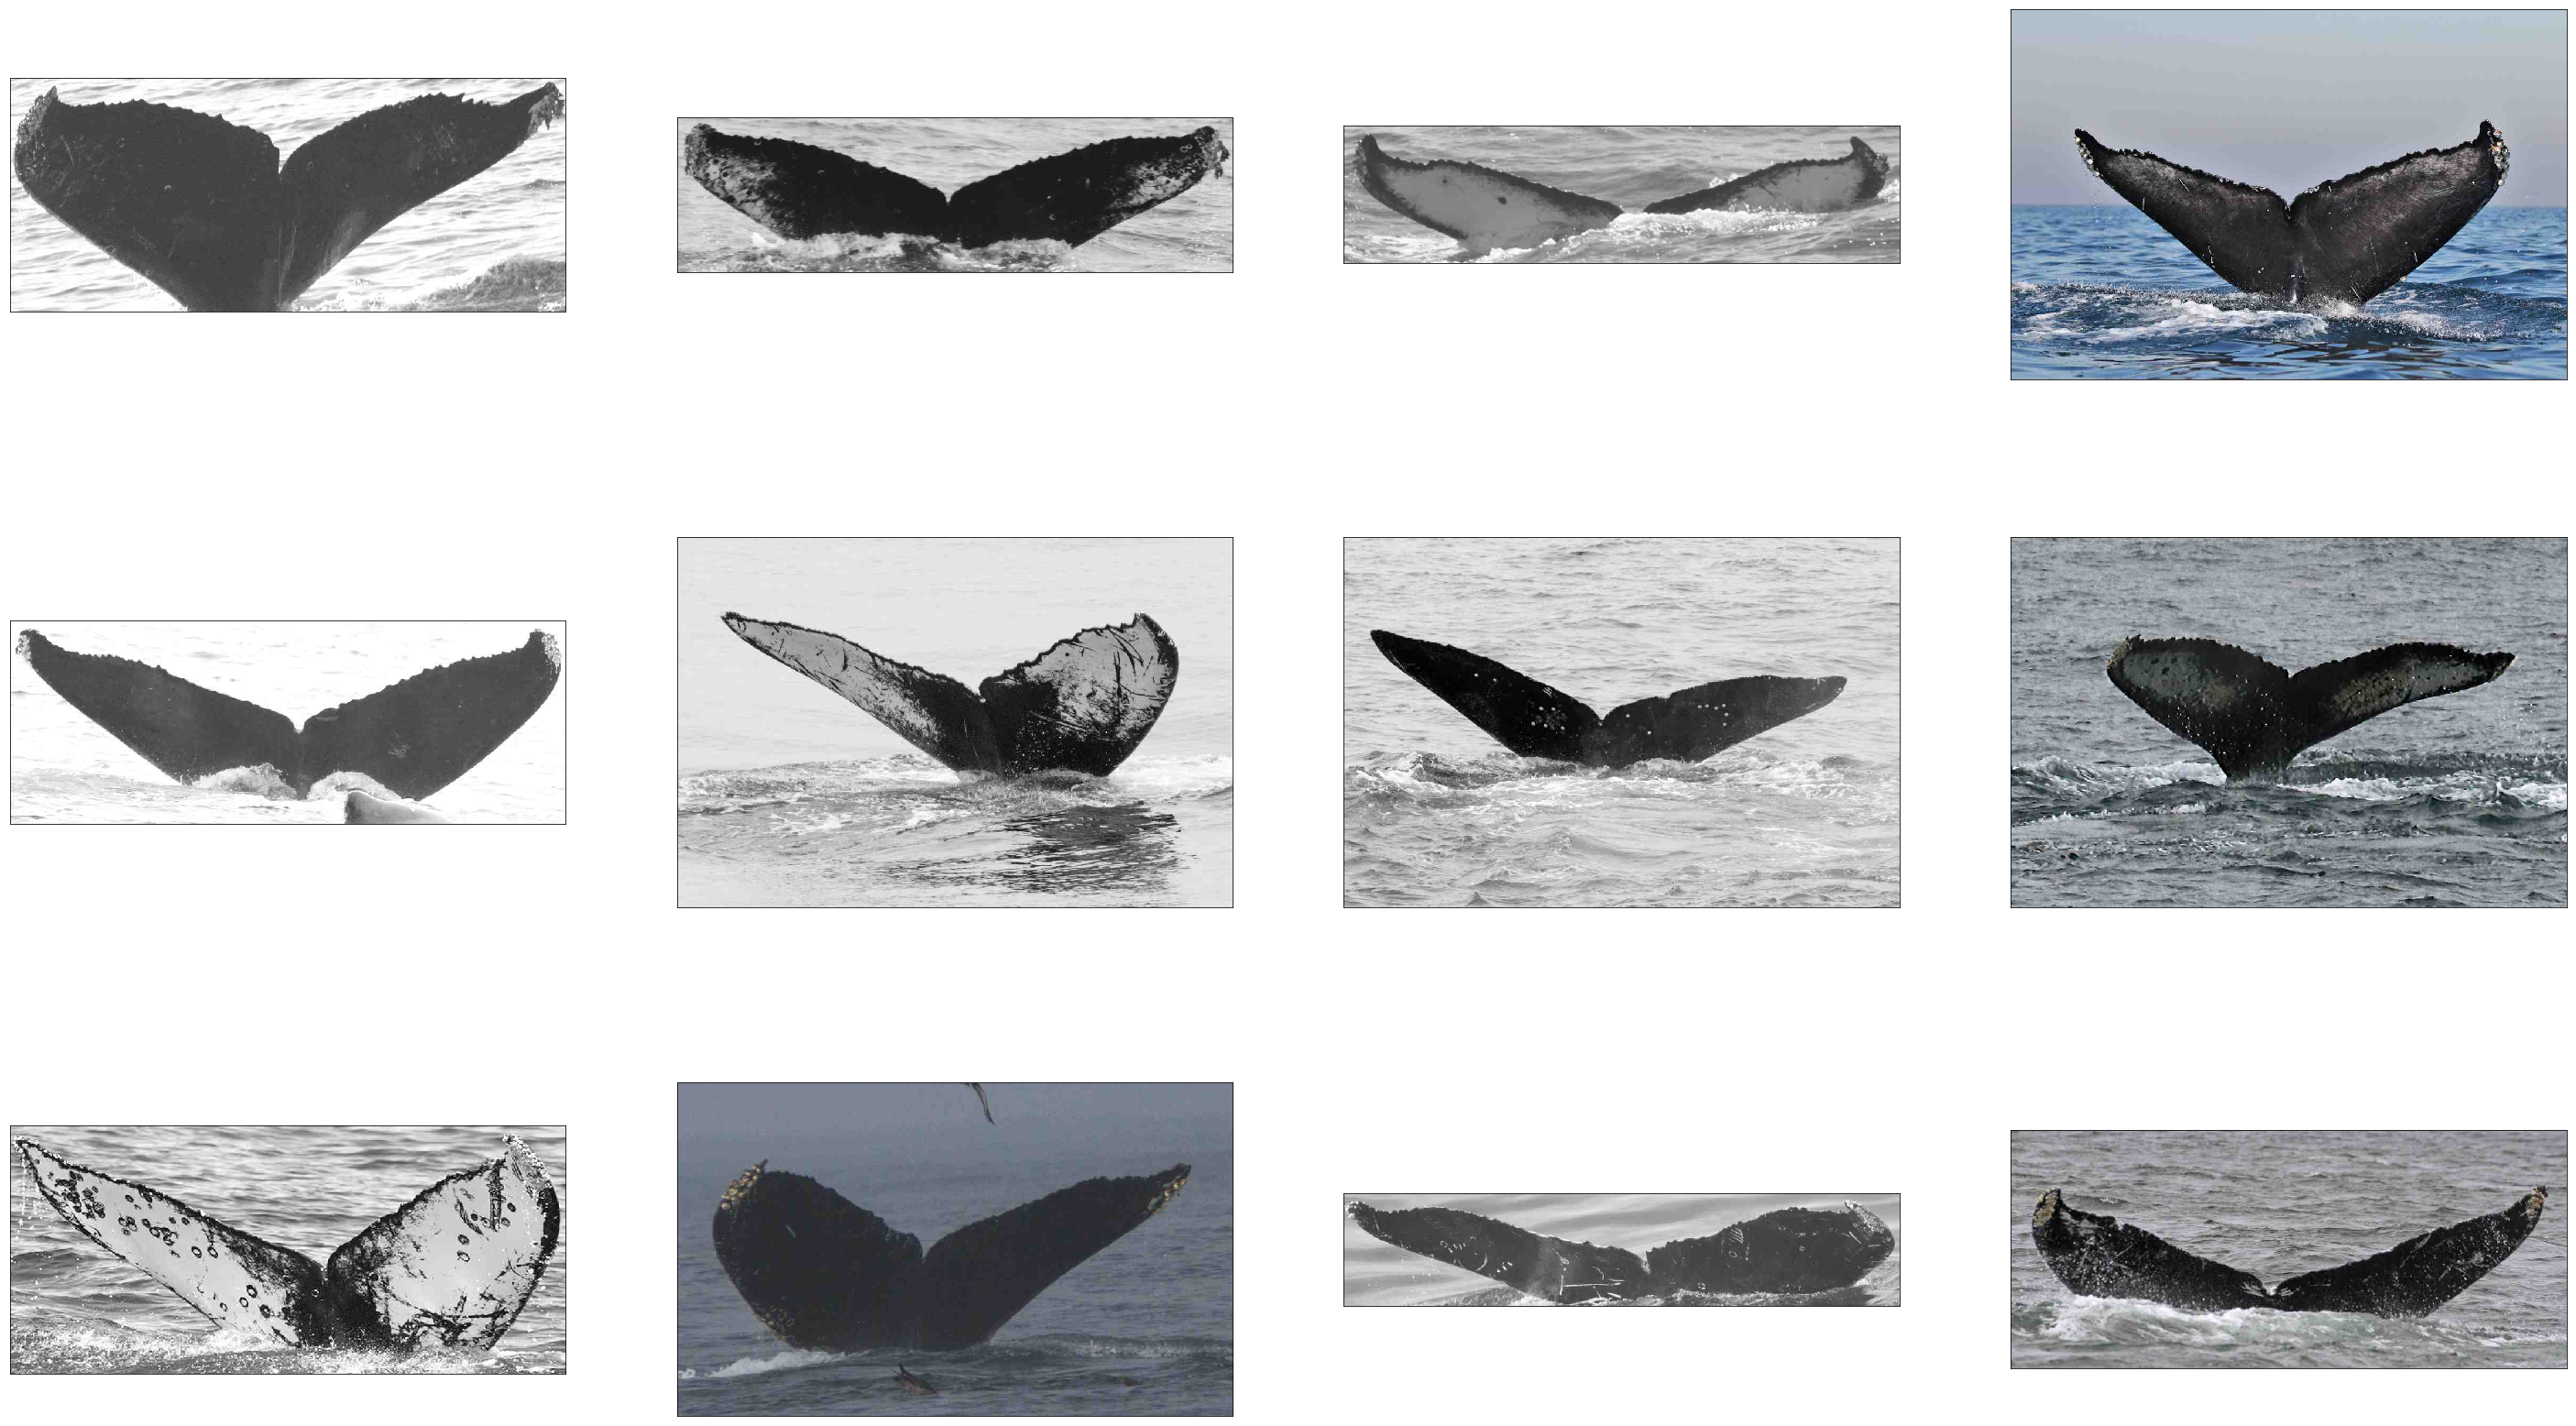

In [3]:
def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(50, 30))

num_images = 12
rand_images = random.sample(X_train, num_images)
for i in range(num_images):
    ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
    visualize_img(rand_images[i], ax)

# Prepare Dataset for ImageDataGenerator

In [4]:
def copy_class_of_files(files, dst, labels):
    for idx, val in enumerate(files):
        dst_dir = os.path.join(dst, labels[idx])
        pathlib.Path(dst_dir).mkdir(parents=True, exist_ok=True)
        shutil.copy(val, dst_dir)
        
shutil.rmtree('./data', ignore_errors=True)
copy_class_of_files(X_train, 'data/train', y_train)
copy_class_of_files(X_valid, 'data/valid', y_valid)
copy_class_of_files(X_test, 'data/test', y_test)

# Load CNN without top layer

In [5]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.models import Model

# define InceptionResNetV2 model
image_side_size = 150
image_dim = (image_side_size, image_side_size, 3)
base_model = VGG19(weights='imagenet', include_top=False,
                          input_tensor=None, input_shape = image_dim, 
                          pooling=None)
print(f"Layers {len(base_model.layers)}")

# freeze weights in all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

print("Complete model before trimming")
base_model.summary()

cut_off_layer = base_model.get_layer('block4_pool')
# https://github.com/keras-team/keras/issues/8909#issuecomment-354406145
# https://github.com/keras-team/keras/issues/2371
base_model = Model(base_model.input, cut_off_layer.output)

print(f'Last base layer: {base_model.output}')

print("Trimmed model")
base_model.summary()

Layers 22
Complete model before trimming
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None,

# Top layer specific to our problem

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.2)(x)

predictions = Dense(num_classes, activation='softmax')(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model

In [7]:
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

# Define image generators

In [8]:
from keras.preprocessing.image import ImageDataGenerator

target_size = (image_side_size, image_side_size)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        shear_range=0.2,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)

print("Train generator")
train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size = target_size,
        class_mode = 'categorical',
        batch_size = batch_size,
        shuffle=True)

print("Valid generator")
valid_generator = valid_datagen.flow_from_directory(
        'data/valid',
        target_size = target_size,
        class_mode = 'categorical',
        batch_size = batch_size)

Train generator
Found 548 images belonging to 60 classes.
Valid generator
Found 167 images belonging to 60 classes.


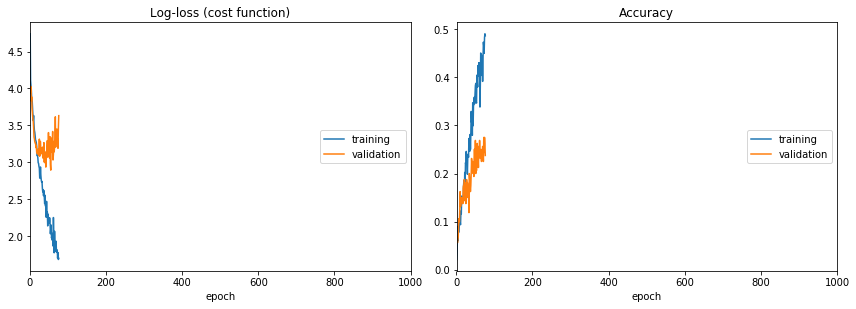

Epoch 77/1000
 7/17 [===========>..................] - ETA: 1:17 - loss: 1.6361 - acc: 0.4955

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

best_weights_path='whale.flukes.weights.best.hdf5'

# train the model
checkpointer = ModelCheckpoint(filepath=best_weights_path, verbose=1, save_best_only=True)

# Stop the training if the model shows no improvement 
stopper = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=100, verbose=1, mode='auto')

model.fit_generator(generator=train_generator,
                    epochs=1000,
                    steps_per_epoch = len(X_train)//batch_size,
                    validation_data=valid_generator, 
                    validation_steps = len(X_valid)//batch_size,
                    callbacks=[checkpointer, stopper, 
                               PlotLossesKeras(), 
                               TensorBoard(log_dir='./logs', batch_size=batch_size)], 
                    verbose=1, workers=workers)


# Load the Model with the Best Validation Loss

In [10]:
model.load_weights(best_weights_path)

# Calculate Classification Accuracy on Test Set

In [11]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    "data/test",
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical', shuffle=False)

score = model.evaluate_generator(
    generator=test_generator, 
    workers=workers)

print("Loss: ", score[0], "Accuracy: ", score[1])

scores = model.predict_generator(
    generator=test_generator, 
    workers=workers)

Found 214 images belonging to 60 classes.
Loss:  3.0484281232423873 Accuracy:  0.2757009340223865


# Print confusion matrix

Confusion matrix, without normalization
Normalized confusion matrix


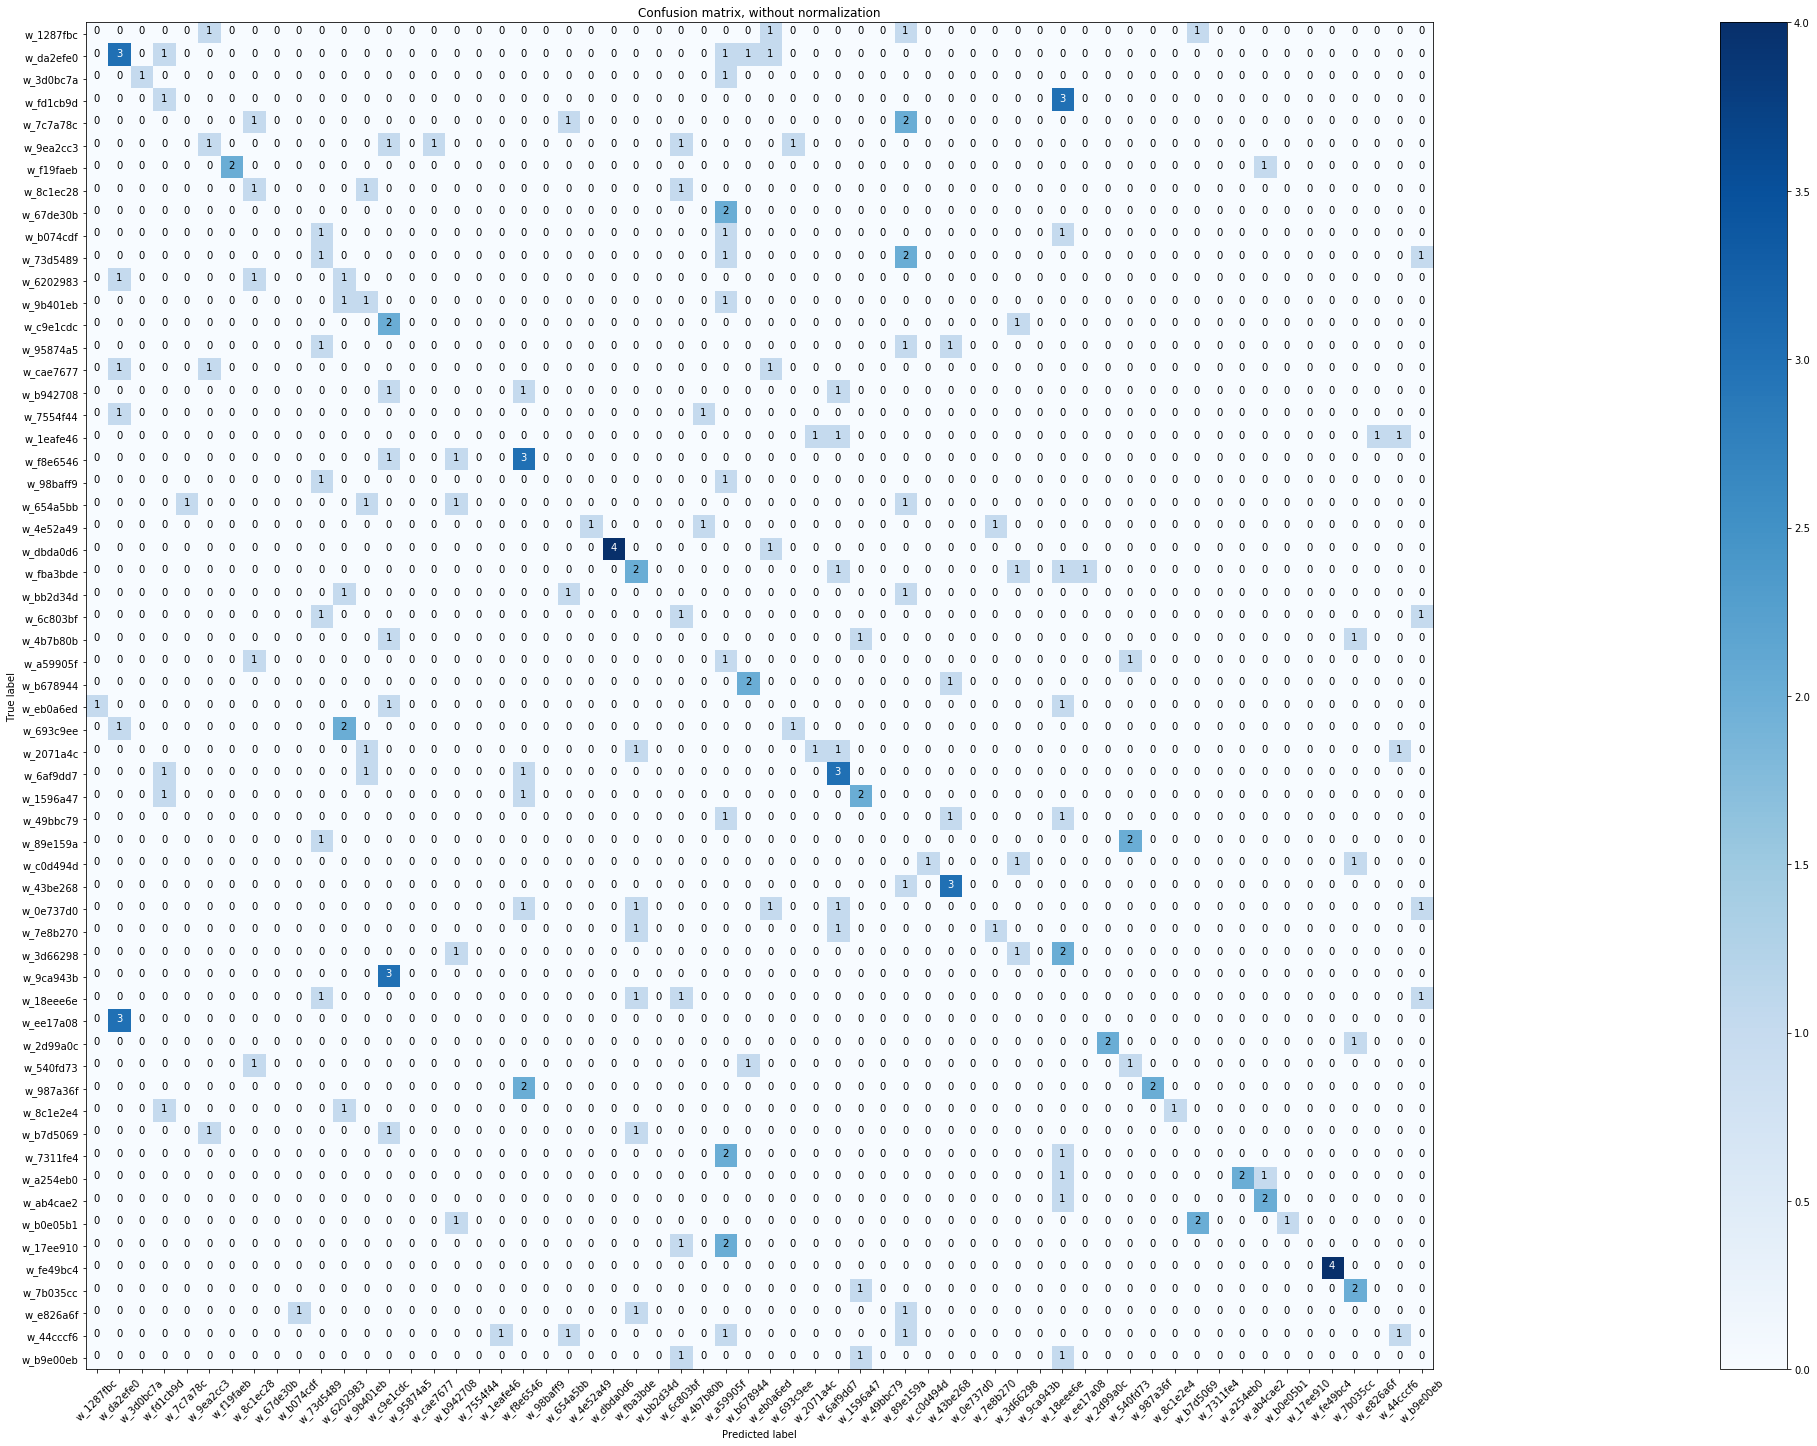

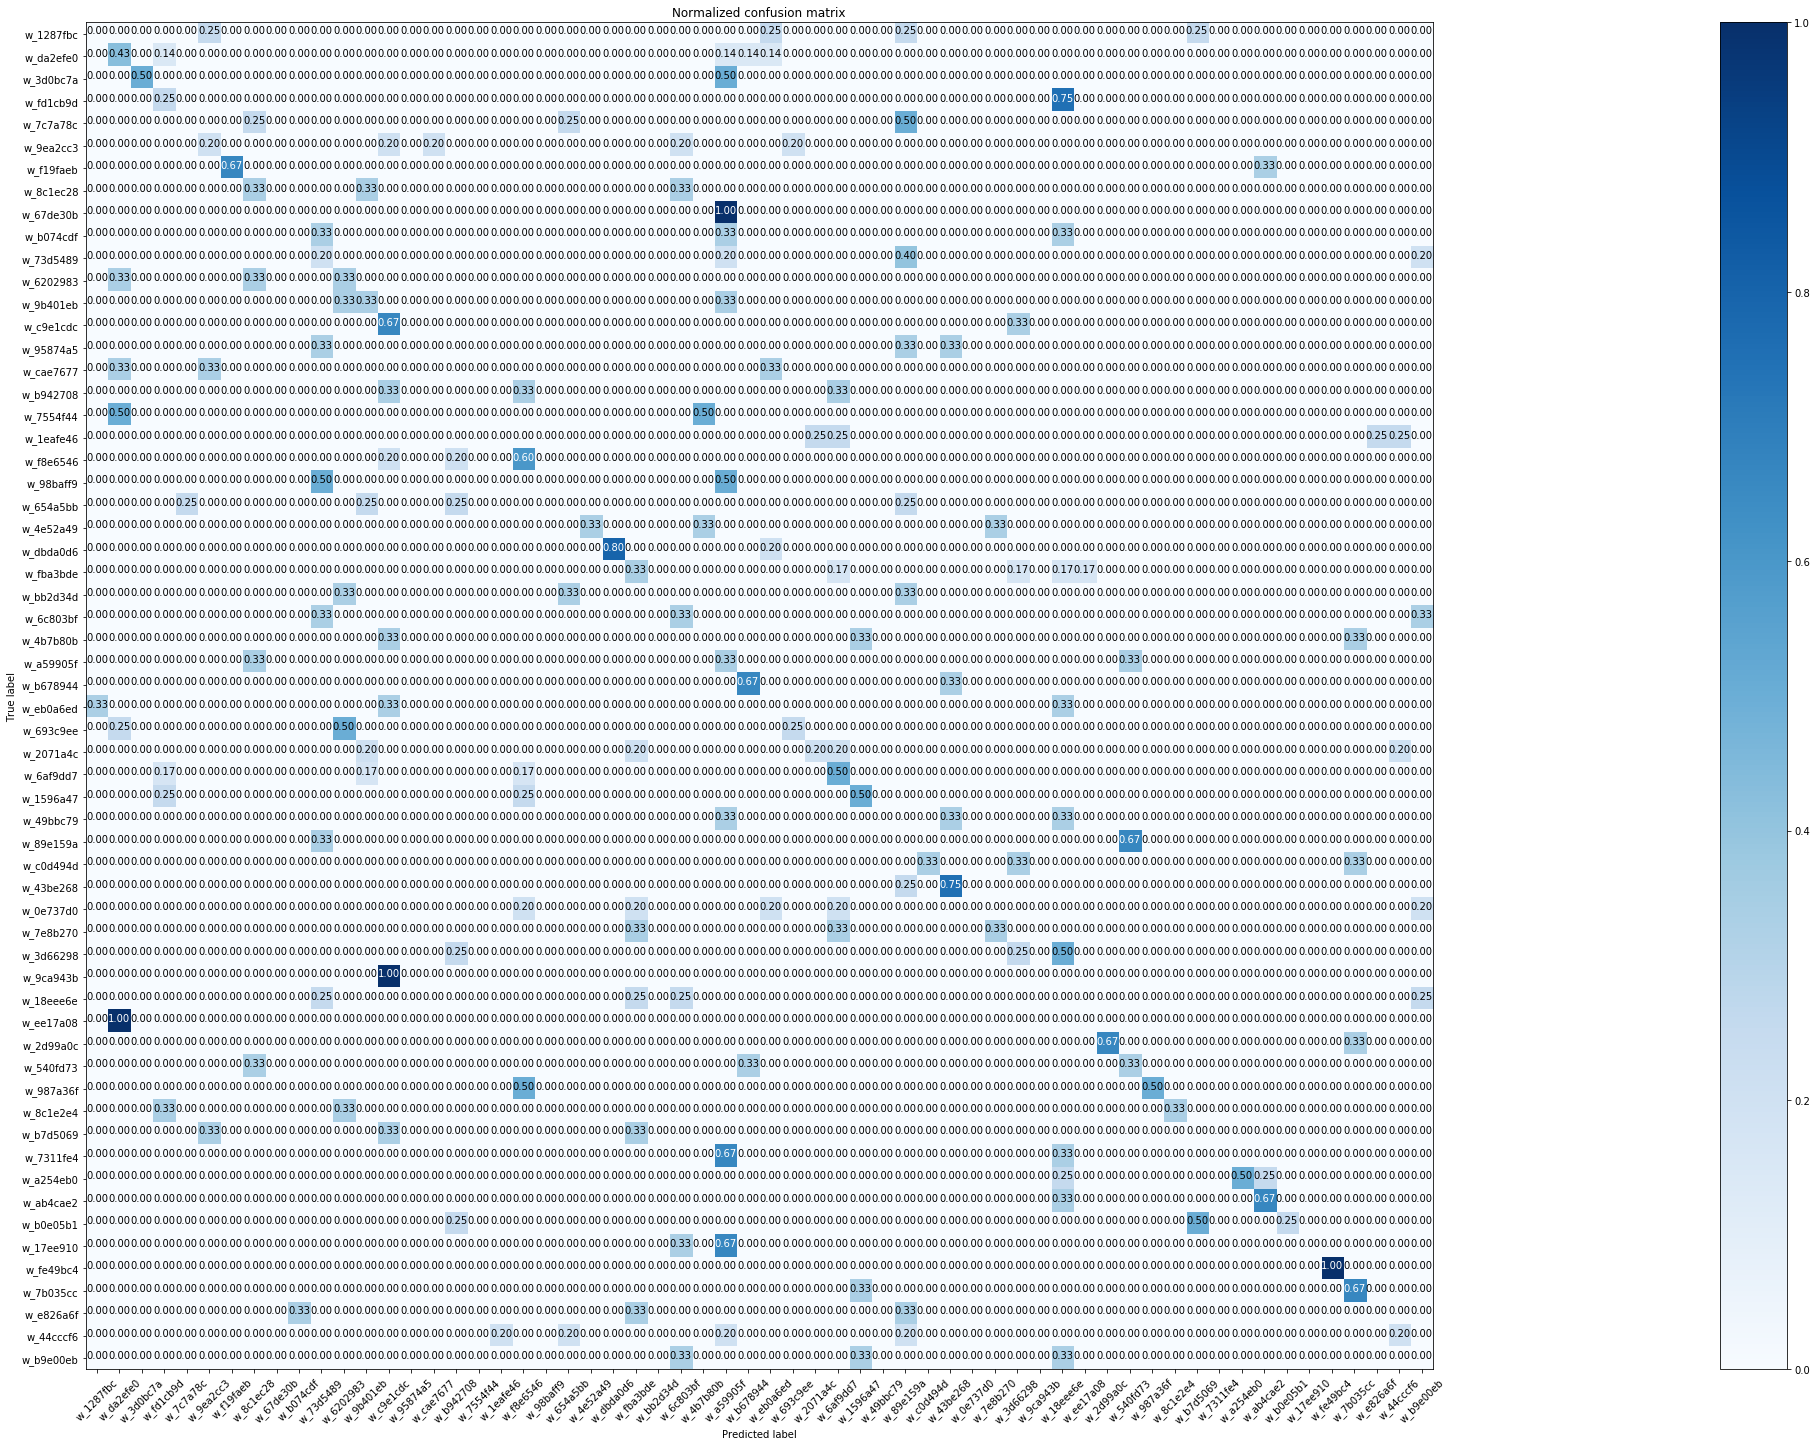

In [13]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(test_generator.classes, list(map(lambda x: np.argmax(x), scores)))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(80,20))
plot_confusion_matrix(cnf_matrix, classes=classes, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(80,20))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

# Write classification result

In [14]:
import csv
import ntpath

with open('predictions.csv', 'w') as csvfile:
    fieldnames = ['Image', 'Id']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    
    for idx, file_name in enumerate(X_test):
        probs = scores[idx]
        _, sorted_classes = zip(*sorted(zip(probs, classes), reverse=True))
        writer.writerow(dict(zip(fieldnames, [ntpath.basename(file_name), ' '.join(sorted_classes[:3])])))